<a href="https://colab.research.google.com/github/BruceGabr/Neurokup-III/blob/main/notebooks/03_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [346]:
!rm -rf ~/.kaggle           # Eliminar archivos antiguos
!rm -rf ~/.config/kaggle    # Eliminar configuraciones alternativas

import os
import json
for var in ['KAGGLE_USERNAME', 'KAGGLE_KEY', 'KAGGLE_API_TOKEN']:
    os.environ.pop(var, None)  # Eliminar variables de entorno viejas

In [347]:
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [348]:
# ========== 1. DEFINIR DIRECTORIO ==========
kaggle_dir = os.path.expanduser('~/.kaggle')
# ========== 3. CONFIGURACIÓN ==========
config = {
    "username": "brucemg",
    "key": "a09e6281740a6fe675766513592210d7"  # Reemplaza con tu key real
}

# Crear archivo NUEVO desde cero
with open(f'{kaggle_dir}/kaggle.json', 'w') as f:
    json.dump(config, f)

# Establecer variables de entorno NUEVAS
os.environ['KAGGLE_USERNAME'] = config['username']
os.environ['KAGGLE_KEY'] = config['key']

In [349]:
!kaggle config view

Configuration values from /root/.kaggle
- username: brucemg
- path: None
- proxy: None
- competition: None


In [350]:
!pip install -q kaggle

In [351]:
!kaggle competitions list | head

ref                                                                                 deadline             category                reward  teamCount  userHasEntered  
----------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/ai-mathematical-olympiad-progress-prize-3       2026-04-15 23:59:00  Featured         2,207,152 Usd       1068           False  
https://www.kaggle.com/competitions/vesuvius-challenge-surface-detection            2026-02-13 23:59:00  Research           200,000 Usd        496           False  
https://www.kaggle.com/competitions/google-tunix-hackathon                          2026-01-12 23:59:00  Featured           100,000 Usd        104           False  
https://www.kaggle.com/competitions/csiro-biomass                                   2026-01-28 23:59:00  Research            75,000 Usd       2787           False  
https://ww

# Cargar datos

In [352]:
!kaggle competitions download -c neuro-kup-iii-beta
!unzip neuro-kup-iii-beta.zip

neuro-kup-iii-beta.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  neuro-kup-iii-beta.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Importar librerías

In [353]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display

# Preprocesamiento

### Leer datasets

In [354]:
train = pd.read_csv('train.csv')
test_private = pd.read_csv('test_private.csv')
test_public = pd.read_csv('test_public.csv')

### Crear copias d elos datasets

In [355]:
train_copy = train.copy()
test_private_copy = test_private.copy()
test_public_copy = test_public.copy()

### Eliminar columnas que no aportan

In [356]:
def limpiar_columnas(df):
  drop_cols = ["id", "nombre", "apellido", "DNI"]
  df_copy = df.drop(columns=drop_cols)
  if "y" in df_copy.columns:
    df_copy['y'] = df_copy['y'].map({'si': 1, 'no': 0})
  return df_copy


In [357]:
train_copy = limpiar_columnas(train_copy)
test_private_copy = limpiar_columnas(test_private_copy)
test_public_copy = limpiar_columnas(test_public_copy)

In [358]:
train_copy.info()
test_public_copy.info()
test_private_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36168 entries, 0 to 36167
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   año_nacimiento         36168 non-null  int64  
 1   trabajo                36168 non-null  object 
 2   estado_civil           36168 non-null  object 
 3   educación              36168 non-null  object 
 4   riesgo_crediticio      36168 non-null  object 
 5   fondos_promedio_anual  36168 non-null  float64
 6   hipoteca               36168 non-null  object 
 7   deuda_personal         36168 non-null  object 
 8   incumplimiento         36168 non-null  object 
 9   contacto               36168 non-null  object 
 10  fecha                  36168 non-null  object 
 11  duracion               36168 non-null  object 
 12  campaña                36168 non-null  int64  
 13  p_dias                 36168 non-null  object 
 14  contactos_previos      36168 non-null  int64  
 15  p_

In [359]:
display(train_copy["y"].value_counts())
display(test_public_copy["y"].value_counts())

,count
y,
0,31970
1,4198


,count
y,
0,3994
1,527


### Preprocesar columna "trabajo"

In [360]:
"""
ESTANDARIZACIÓN - COLUMNA 'trabajo'
Solo unificar mayúsculas/minúsculas y variaciones ortográficas
"""

import pandas as pd

# ========== FUNCIÓN DE ESTANDARIZACIÓN ==========
def estandarizar_trabajo(df):
    """
    Unifica solo variaciones de escritura de la misma categoría
    """
    df = df.copy()

    # 1. Convertir todo a minúsculas y quitar espacios extras
    df['trabajo'] = df['trabajo'].str.lower().str.strip()

    # 2. Mapeo SOLO de variaciones ortográficas
    mapeo_estandarizacion = {
        # Técnico (con y sin tilde)
        'tecnico': 'técnico',

        # Autónomo (con y sin tilde, con typo)
        'autónomo': 'autónomo',
        'autonomo': 'autónomo',  # sin tilde

        # Criado/a (unificar formato)
        'criada(o)': 'criado/a',
        'criado(a)': 'criado/a',

        # Servicio/servicios (unificar plural)
        'servicios': 'servicio',

        # Desconocidos (unificar todas las formas)
        'no se conoce': 'desconocido',
        'sin información': 'desconocido',
        'no se sabe': 'desconocido',
    }

    # 3. Aplicar mapeo
    df['trabajo'] = df['trabajo'].replace(mapeo_estandarizacion)

    return df

# ========== APLICAR ==========
train_clean = estandarizar_trabajo(train_copy)
test_public_clean = estandarizar_trabajo(test_public_copy)
test_private_clean = estandarizar_trabajo(test_private_copy)

print("Distribución DESPUÉS (estandarizada):")
print(train_clean['trabajo'].value_counts())
print(f"\n   Categorías finales: {train_clean['trabajo'].nunique()}")

print(f"\nReducción: {train_clean['trabajo'].nunique()} categorías")

Distribución DESPUÉS (estandarizada):
trabajo
obrero             7806
gestión            7500
técnico            5131
servicio           3350
administrativo     2904
autónomo           1286
administrador      1233
emprendedor        1178
criado/a           1002
experto técnico     965
jubilado            915
retirado            900
desempleado         805
estudiante          742
desconocido         233
desocupado          218
Name: count, dtype: int64

   Categorías finales: 16

Reducción: 16 categorías


In [361]:
"""
PASO 2: UNIFICAR SINÓNIMOS
"""

def unificar_sinonimos_trabajo(df):
    """
    Unifica categorías que son exactamente lo mismo
    """
    df = df.copy()

    # Mapeo de sinónimos
    sinonimos = {
        'retirado': 'jubilado',          # Mismo significado
        'desocupado': 'desempleado',     # Mismo significado
    }

    df['trabajo'] = df['trabajo'].replace(sinonimos)

    return df

# Aplicar
train_clean = unificar_sinonimos_trabajo(train_clean)
test_public_clean = unificar_sinonimos_trabajo(test_public_clean)
test_private_clean = unificar_sinonimos_trabajo(test_private_clean)

# Verificar
print("Sinónimos unificados\n")
print("Distribución final:")
print(train_clean['trabajo'].value_counts())
print(f"\nCategorías finales: {train_clean['trabajo'].nunique()}")

Sinónimos unificados

Distribución final:
trabajo
obrero             7806
gestión            7500
técnico            5131
servicio           3350
administrativo     2904
jubilado           1815
autónomo           1286
administrador      1233
emprendedor        1178
desempleado        1023
criado/a           1002
experto técnico     965
estudiante          742
desconocido         233
Name: count, dtype: int64

Categorías finales: 14


In [362]:
display(train_clean.head())

,año_nacimiento,trabajo,estado_civil,educación,riesgo_crediticio,fondos_promedio_anual,hipoteca,deuda_personal,incumplimiento,contacto,fecha,duracion,campaña,p_dias,contactos_previos,p_resultado,y
0,1984,obrero,"casado, con hijos",primaria,no,849.0,sí,Falso,NO,Desconocido,15-may,1 m 12 s,1,nunca,0,desconocido,0
1,1976,técnico,"casado, sin hijos",primaria,no,1415.0,sí,Falso,NO,CEL,30-jul,4 m 29 s,2,nunca,0,desconocido,0
2,1983,administrador,"casado, con hijos",secundaria,no,3842.0,no,Falso,NO,CEL,31-jul,2 m 10 s,4,nunca,0,Desconocido,0
3,1988,gestión,soltero,superios,no,-119.0,sí,Falso,NO,desconocido,11-ene,6 m 15 s,11,nunca,0,desconocido,0
4,1969,obrero,"casado, con hijos",primaria,no,3498.0,No,Falso,NO,CEL,15-abr,4 m 24 s,2,nunca,0,desconocido,1


### Preprocesar columna "estado_civil"

In [363]:
"""
=================================================================
PREPROCESAMIENTO - COLUMNA 'estado_civil'
=================================================================
"""

def limpiar_estado_civil(df):
    """
    Limpia la columna 'estado_civil'
    - Normaliza formato
    - Unifica tipos de divorcio
    """
    df = df.copy()

    # Normalizar (minúsculas, espacios)
    df['estado_civil'] = df['estado_civil'].str.lower().str.strip()

    # Unificar divorcios
    mapeo = {
        'divorcio voluntario': 'divorciado',
        'divorcio contencioso': 'divorciado',
    }

    df['estado_civil'] = df['estado_civil'].replace(mapeo)

    return df

# ========== APLICAR ==========
train_clean = limpiar_estado_civil(train_clean)
test_public_clean = limpiar_estado_civil(test_public_clean)
test_private_clean = limpiar_estado_civil(test_private_clean)

# ========== VERIFICAR ==========
print("Columna 'estado_civil' limpia")
print(f" Categorías: {train_clean['estado_civil'].nunique()}")
print("\n Distribución:")
print(train_clean['estado_civil'].value_counts())

Columna 'estado_civil' limpia
 Categorías: 4

 Distribución:
estado_civil
casado, sin hijos    10918
casado, con hijos    10886
soltero              10221
divorciado            4143
Name: count, dtype: int64


### Preprocesar columna "educación"

In [364]:
"""
=================================================================
PREPROCESAMIENTO - COLUMNA 'educación'
=================================================================
"""

def limpiar_educacion(df):
    """
    Limpia y estandariza la columna 'educación'

    Cambios:
    - Normaliza a minúsculas
    - Corrige typos: 'superios' → 'superior', 'primari@' → 'primaria'
    - Unifica valores desconocidos → 'desconocido'

    Returns:
        df: DataFrame con columna limpia (4 categorías)
    """
    df = df.copy()

    # Normalizar formato (minúsculas, espacios)
    df['educación'] = df['educación'].str.lower().str.strip()

    # Corregir typos y unificar
    mapeo = {
        # Typos ortográficos
        'superios': 'superior',
        'primari@': 'primaria',

        # Valores desconocidos
        'sin información': 'desconocido',
        'no se conoce': 'desconocido',
        'no se sabe': 'desconocido',
    }

    df['educación'] = df['educación'].replace(mapeo)

    return df

# ========== APLICAR ==========
train_clean = limpiar_educacion(train_clean)
test_public_clean = limpiar_educacion(test_public_clean)
test_private_clean = limpiar_educacion(test_private_clean)

# ========== VERIFICAR ==========
print("="*60)
print("LIMPIEZA COLUMNA 'educación' - COMPLETADA")
print("="*60)

print(f"\n Categorías: 10 → {train_clean['educación'].nunique()}")
print("\n Distribución final:")
print(train_clean['educación'].value_counts())

print("\n Preprocesamiento completo")


LIMPIEZA COLUMNA 'educación' - COMPLETADA

 Categorías: 10 → 4

 Distribución final:
educación
secundaria     18670
superior       10539
primaria        5476
desconocido     1483
Name: count, dtype: int64

 Preprocesamiento completo


### Preprocesar columna "riesgo_crediticio"

In [365]:
# Convertir a booleano
train_clean['tiene_riesgo'] = train_clean['riesgo_crediticio'].map({'no': 0, 'sí': 1})
test_public_clean['tiene_riesgo'] = test_public_clean['riesgo_crediticio'].map({'no': 0, 'sí': 1})
test_private_clean['tiene_riesgo'] = test_private_clean['riesgo_crediticio'].map({'no': 0, 'sí': 1})

In [366]:
# Luego eliminar la original
train_clean = train_clean.drop('riesgo_crediticio', axis=1)
test_public_clean = test_public_clean.drop('riesgo_crediticio', axis=1)
test_private_clean = test_private_clean.drop('riesgo_crediticio', axis=1)

In [367]:
print(f"\n tiene_riesgo:")
print(train_clean["tiene_riesgo"].value_counts())
print(f"Valores únicos: {train_clean["tiene_riesgo"].nunique()}")


 tiene_riesgo:
tiene_riesgo
0    35491
1      677
Name: count, dtype: int64
Valores únicos: 2


### Preprocesar columna "hipoteca"

In [368]:
"""
=================================================================
PREPROCESAMIENTO - COLUMNA 'hipoteca'
=================================================================
"""

def limpiar_hipoteca(df):
    """
    Limpia y estandariza la columna 'hipoteca'

    Cambios:
    - Normaliza a minúsculas
    - Unifica 'Sí'/'sí' → 'sí'
    - Unifica 'No'/'no' → 'no'

    Returns:
        df: DataFrame con columna limpia (2 categorías)
    """
    df = df.copy()

    # Normalizar a minúsculas
    df['hipoteca'] = df['hipoteca'].str.lower().str.strip()

    return df

# ========== APLICAR ==========
train_clean = limpiar_hipoteca(train_clean)
test_public_clean = limpiar_hipoteca(test_public_clean)
test_private_clean = limpiar_hipoteca(test_private_clean)

# ========== VERIFICAR ==========
print("="*60)
print("LIMPIEZA COLUMNA 'hipoteca' - COMPLETADA")
print("="*60)

print(f"\n Categorías: 4 → {train_clean['hipoteca'].nunique()}")
print("\n Distribución final:")
print(train_clean['hipoteca'].value_counts())

# Verificar valores
valores_esperados = {'sí', 'no'}
valores_reales = set(train_clean['hipoteca'].unique())

if valores_reales == valores_esperados:
    print("\n Limpieza exitosa - 2 categorías correctas")
else:
    print(f"\n  Valores inesperados: {valores_reales}")

# Verificar balance
print(f"\n Distribución porcentual:")
print(train_clean['hipoteca'].value_counts(normalize=True) * 100)

LIMPIEZA COLUMNA 'hipoteca' - COMPLETADA

 Categorías: 4 → 2

 Distribución final:
hipoteca
sí    20135
no    16033
Name: count, dtype: int64

 Limpieza exitosa - 2 categorías correctas

 Distribución porcentual:
hipoteca
sí    55.670759
no    44.329241
Name: proportion, dtype: float64


In [369]:
# Convertir a binario (0/1)
train_clean['tiene_hipoteca'] = train_clean['hipoteca'].map({'no': 0, 'sí': 1})
test_public_clean['tiene_hipoteca'] = test_public_clean['hipoteca'].map({'no': 0, 'sí': 1})
test_private_clean['tiene_hipoteca'] = test_private_clean['hipoteca'].map({'no': 0, 'sí': 1})

train_clean = train_clean.drop('hipoteca', axis=1)
test_public_clean = test_public_clean.drop('hipoteca', axis=1)
test_private_clean = test_private_clean.drop('hipoteca', axis=1)

In [370]:
# Verificar balance
print(f"\n Distribución porcentual:")
print(train_clean['tiene_hipoteca'].value_counts(normalize=True) * 100)


 Distribución porcentual:
tiene_hipoteca
1    55.670759
0    44.329241
Name: proportion, dtype: float64


### Preprocesar columna "deuda_personal"

In [371]:
# Opción A: Booleano (True/False)
train_clean['deuda_personal'] = train_clean['deuda_personal'].map({
    'Falso': False,
    'Verdadero': True
})
test_public_clean['deuda_personal'] = test_public_clean['deuda_personal'].map({
    'Falso': False,
    'Verdadero': True
})
test_private_clean['deuda_personal'] = test_private_clean['deuda_personal'].map({
    'Falso': False,
    'Verdadero': True
})
# Verificar balance
print(f"\n Distribución porcentual:")
print(train_clean['deuda_personal'].value_counts(normalize=True) * 100)


 Distribución porcentual:
deuda_personal
False    83.866954
True     16.133046
Name: proportion, dtype: float64


### Preprocesar columna "incumplimiento"

In [372]:
"""
VERIFICACIÓN CORRECTA DE COLUMNAS DUPLICADAS
"""

# Convertir a numérico
train_clean['incumplimiento'] = train_clean['incumplimiento'].map({'NO': 0, 'SÍ': 1})
test_public_clean['incumplimiento'] = test_public_clean['incumplimiento'].map({'NO': 0, 'SÍ': 1})
test_private_clean['incumplimiento'] = test_private_clean['incumplimiento'].map({'NO': 0, 'SÍ': 1})

# ========== FORMA CORRECTA: Comparar valores fila por fila ==========

# Verificar en cada dataset
print("="*60)
print("VERIFICACIÓN DE DUPLICADOS")
print("="*60)

# Train
train_iguales = (train_clean['tiene_riesgo'] == train_clean['incumplimiento']).all()
print(f"\n TRAIN:")
print(f"   ¿Son idénticas? {train_iguales}")
if not train_iguales:
    diferentes = (train_clean['tiene_riesgo'] != train_clean['incumplimiento']).sum()
    print(f"   Filas diferentes: {diferentes} ({diferentes/len(train_clean)*100:.2f}%)")

# Test Public
test_pub_iguales = (test_public_clean['tiene_riesgo'] == test_public_clean['incumplimiento']).all()
print(f"\n TEST PUBLIC:")
print(f"   ¿Son idénticas? {test_pub_iguales}")
if not test_pub_iguales:
    diferentes = (test_public_clean['tiene_riesgo'] != test_public_clean['incumplimiento']).sum()
    print(f"   Filas diferentes: {diferentes} ({diferentes/len(test_public_clean)*100:.2f}%)")

# Test Private
test_priv_iguales = (test_private_clean['tiene_riesgo'] == test_private_clean['incumplimiento']).all()
print(f"\n TEST PRIVATE:")
print(f"   ¿Son idénticas? {test_priv_iguales}")
if not test_priv_iguales:
    diferentes = (test_private_clean['tiene_riesgo'] != test_private_clean['incumplimiento']).sum()
    print(f"   Filas diferentes: {diferentes} ({diferentes/len(test_private_clean)*100:.2f}%)")

# ========== DECISIÓN ==========
print("\n" + "="*60)
print("DECISIÓN")
print("="*60)

if train_iguales and test_pub_iguales and test_priv_iguales:
    print("\n COLUMNAS DUPLICADAS en TODOS los datasets")
    print("   → Eliminando 'incumplimiento'...")

    # Eliminar en todos
    train_clean = train_clean.drop('incumplimiento', axis=1)
    test_public_clean = test_public_clean.drop('incumplimiento', axis=1)
    test_private_clean = test_private_clean.drop('incumplimiento', axis=1)

    print("    Columna 'incumplimiento' eliminada de todos los datasets")
    print("    Mantenida columna 'tiene_riesgo'")
else:
    print("\n Las columnas son diferentes en al menos un dataset")
    print("   → Se mantienen ambas columnas")

VERIFICACIÓN DE DUPLICADOS

 TRAIN:
   ¿Son idénticas? True

 TEST PUBLIC:
   ¿Son idénticas? True

 TEST PRIVATE:
   ¿Son idénticas? True

DECISIÓN

 COLUMNAS DUPLICADAS en TODOS los datasets
   → Eliminando 'incumplimiento'...
    Columna 'incumplimiento' eliminada de todos los datasets
    Mantenida columna 'tiene_riesgo'


### Preprocesar columna "contacto"

In [373]:
"""
=================================================================
PREPROCESAMIENTO - COLUMNA 'contacto'
=================================================================
"""

def limpiar_contacto(df):
    """
    Limpia y estandariza la columna 'contacto'

    Unifica:
    - CELL, CEL, celular, Celular → celular
    - teléfono, TEL, Teléfono → telefono
    - Desconocido, desconocido → desconocido
    """
    df = df.copy()

    # Normalizar a minúsculas
    df['contacto'] = df['contacto'].str.lower().str.strip()

    # Mapeo de estandarización
    mapeo = {
        # Variaciones de "celular"
        'cell': 'celular',
        'cel': 'celular',

        # Variaciones de "teléfono"
        'teléfono': 'telefono',  # Quitar tilde
        'tel': 'telefono',
    }

    df['contacto'] = df['contacto'].replace(mapeo)

    return df

# ========== APLICAR ==========
train_clean = limpiar_contacto(train_clean)
test_public_clean = limpiar_contacto(test_public_clean)
test_private_clean = limpiar_contacto(test_private_clean)

# ========== VERIFICAR ==========
print("="*60)
print("LIMPIEZA COLUMNA 'contacto' - COMPLETADA")
print("="*60)

print(f"\n Categorías: 9 → {train_clean['contacto'].nunique()}")
print("\n Distribución final:")
print(train_clean['contacto'].value_counts())

# Verificar valores esperados
valores_esperados = {'celular', 'telefono', 'desconocido'}
valores_reales = set(train_clean['contacto'].unique())

if valores_reales == valores_esperados:
    print("\n Limpieza exitosa - 3 categorías correctas")
else:
    print(f"\n  Valores inesperados: {valores_reales}")

# Distribución porcentual
print("\n Distribución porcentual:")
print(train_clean['contacto'].value_counts(normalize=True).sort_values(ascending=False) * 100)

LIMPIEZA COLUMNA 'contacto' - COMPLETADA

 Categorías: 9 → 3

 Distribución final:
contacto
celular        23464
desconocido    10385
telefono        2319
Name: count, dtype: int64

 Limpieza exitosa - 3 categorías correctas

 Distribución porcentual:
contacto
celular        64.875028
desconocido    28.713227
telefono        6.411745
Name: proportion, dtype: float64


### Preprocesar columna "fecha"

In [374]:
"""
=================================================================
PREPROCESAMIENTO - COLUMNA 'fecha'
Extrae solo el mes (12 categorías)
=================================================================
"""

import pandas as pd

def limpiar_fecha(df):
    """
    Extrae solo el mes de la columna 'fecha'

    Convierte:
    - "15-may" → 5 (mayo)
    - "7-dic" → 12 (diciembre)
    - "22-ene" → 1 (enero)
    - "11-jan" → 6 (junio - corrección de error de tipeo)

    Args:
        df: DataFrame con columna 'fecha' en formato "día-mes"

    Returns:
        df: DataFrame con 'fecha' reemplazada por 'mes' (1-12)
    """
    df = df.copy()

    # Mapeo de meses en español a números
    meses_map = {
        'ene': 1, 'feb': 2, 'mar': 3, 'abr': 4,
        'may': 5, 'jun': 6, 'jul': 7, 'ago': 8,
        'set': 9, 'oct': 10, 'nov': 11, 'dic': 12,
        'jan': 6,  # Error de tipeo en dataset: jan → jun
    }

    # Normalizar a minúsculas
    fecha_clean = df['fecha'].str.lower().str.strip()

    # Extraer solo la parte del mes (después del guion)
    mes_txt = fecha_clean.str.extract(r'([a-z]+)')[0]

    # Mapear a número
    df['mes'] = mes_txt.map(meses_map)

    # Eliminar columna fecha original
    df = df.drop('fecha', axis=1)

    return df

# ========== APLICAR ==========
train_clean = limpiar_fecha(train_clean)
test_public_clean = limpiar_fecha(test_public_clean)
test_private_clean = limpiar_fecha(test_private_clean)

# ========== VERIFICAR ==========
print("="*60)
print("LIMPIEZA COLUMNA 'fecha' - COMPLETADA")
print("="*60)

print("\n Fecha convertida a mes (1-12)")

print("\n Distribución por mes:")
print(train_clean['mes'].value_counts().sort_index())

print("\n Estadísticas:")
print(f"   Meses únicos: {train_clean['mes'].nunique()}")
print(f"   Rango: {train_clean['mes'].min()} - {train_clean['mes'].max()}")
print(f"   Tipo de dato: {train_clean['mes'].dtype}")

# Verificar que no hay NaN
if train_clean['mes'].isna().sum() > 0:
    print(f"\n  Valores faltantes: {train_clean['mes'].isna().sum()}")
else:
    print(f"\n No hay valores faltantes")

LIMPIEZA COLUMNA 'fecha' - COMPLETADA

 Fecha convertida a mes (1-12)

 Distribución por mes:
mes
1      4318
2      2112
3       374
4      2344
5     10963
6      1135
7      5537
8      4966
9       464
10      599
11     3173
12      183
Name: count, dtype: int64

 Estadísticas:
   Meses únicos: 12
   Rango: 1 - 12
   Tipo de dato: int64

 No hay valores faltantes


### Preprocesar columna "duración"

In [375]:
"""
=================================================================
PREPROCESAMIENTO - COLUMNA 'duracion'
Convierte formato "Xm Ys" a segundos totales
=================================================================
"""

import pandas as pd
import re

def limpiar_duracion(df):
    """
    Limpia y convierte la columna 'duracion' a segundos

    Convierte formatos como:
    - "5m 30s" → 330 segundos
    - "2m" → 120 segundos
    - "45s" → 45 segundos
    - NaN → 0 segundos

    Args:
        df: DataFrame con columna 'duracion'

    Returns:
        df: DataFrame con 'duracion' en segundos (int)
    """
    df = df.copy()

    def duracion_a_segundos(x):
        """
        Convierte string "Xm Ys" a segundos totales
        """
        # Manejar valores nulos
        if pd.isna(x):
            return 0

        # Convertir a string por si acaso
        x = str(x).strip()

        # Extraer minutos y segundos con regex
        minutos = re.search(r"(\d+)\s*m", x, re.IGNORECASE)
        segundos = re.search(r"(\d+)\s*s", x, re.IGNORECASE)

        # Convertir a enteros
        m = int(minutos.group(1)) if minutos else 0
        s = int(segundos.group(1)) if segundos else 0

        # Retornar total en segundos
        return m * 60 + s

    # Aplicar conversión
    df['duracion'] = df['duracion'].apply(duracion_a_segundos)

    # Asegurar que sea tipo int
    df['duracion'] = df['duracion'].astype(int)

    return df

# ========== APLICAR ==========
train_clean = limpiar_duracion(train_clean)
test_public_clean = limpiar_duracion(test_public_clean)
test_private_clean = limpiar_duracion(test_private_clean)

# ========== VERIFICAR ==========
print("="*60)
print("LIMPIEZA COLUMNA 'duracion' - COMPLETADA")
print("="*60)

print("\n Duracion convertida a segundos (int)")

print("\nEstadísticas:")
print(train_clean['duracion'].describe())
# Ordenar por la clase (duracion en segundos), no por frecuencia
print(train_clean['duracion'].value_counts().sort_index())

print("\n Distribución de duraciones:")
print(f"   Mínimo: {train_clean['duracion'].min()} segundos")
print(f"   Máximo: {train_clean['duracion'].max()} segundos")
print(f"   Media: {train_clean['duracion'].mean():.1f} segundos ({train_clean['duracion'].mean()/60:.1f} minutos)")
print(f"   Mediana: {train_clean['duracion'].median()} segundos ({train_clean['duracion'].median()/60:.1f} minutos)")

# Verificar valores nulos (deben ser 0)
print(f"\n Valores = 0 (eran NaN): {(train_clean['duracion'] == 0).sum()}")

# Tipo de dato
print(f"\n Tipo de dato: {train_clean['duracion'].dtype}")


LIMPIEZA COLUMNA 'duracion' - COMPLETADA

 Duracion convertida a segundos (int)

Estadísticas:
count    36168.000000
mean       256.891202
std        256.884103
min          0.000000
25%        103.000000
50%        180.000000
75%        318.000000
max       4918.000000
Name: duracion, dtype: float64
duracion
0        2
1        1
2        2
3        4
4       14
        ..
3366     1
3422     1
3785     1
3881     1
4918     1
Name: count, Length: 1493, dtype: int64

 Distribución de duraciones:
   Mínimo: 0 segundos
   Máximo: 4918 segundos
   Media: 256.9 segundos (4.3 minutos)
   Mediana: 180.0 segundos (3.0 minutos)

 Valores = 0 (eran NaN): 2

 Tipo de dato: int64


### Preprocesar columna "p_dias"

In [376]:
"""
=================================================================
PREPROCESAMIENTO - COLUMNA 'p_dias'
Convierte "nunca" a -1 y asegura tipo int
=================================================================
"""

import pandas as pd

def limpiar_p_dias(df):
    """
    Limpia y convierte la columna 'p_dias'

    Convierte:
    - "nunca" / "Nunca" / "NUNCA" → -1
    - Números como string → int
    - NaN → -1 (asumiendo que significa "nunca contactado")

    Args:
        df: DataFrame con columna 'p_dias'

    Returns:
        df: DataFrame con 'p_dias' en int
    """
    df = df.copy()

    def convertir_p_dias(x):
        """
        Convierte valor a entero, manejando "nunca"
        """
        # Manejar valores nulos
        if pd.isna(x):
            return -1

        # Convertir a string y normalizar
        x_str = str(x).strip().lower()

        # Si es "nunca", retornar -1
        if x_str == "nunca":
            return -1

        # Intentar convertir a entero
        try:
            return int(float(x_str))  # float primero por si tiene decimales
        except ValueError:
            # Si falla, asumir que nunca fue contactado
            return -1

    # Aplicar conversión
    df['p_dias'] = df['p_dias'].apply(convertir_p_dias)

    # Asegurar tipo int
    df['p_dias'] = df['p_dias'].astype(int)

    return df

# ========== APLICAR ==========
train_clean = limpiar_p_dias(train_clean)
test_public_clean = limpiar_p_dias(test_public_clean)
test_private_clean = limpiar_p_dias(test_private_clean)

# ========== VERIFICAR ==========
print("="*60)
print("LIMPIEZA COLUMNA 'p_dias' - COMPLETADA")
print("="*60)

print("\n p_dias convertida a int")

print("\n Estadísticas:")
print(train_clean['p_dias'].describe())

print("\n Valores especiales:")
print(f"   Nunca contactados (-1): {(train_clean['p_dias'] == -1).sum()} ({(train_clean['p_dias'] == -1).sum()/len(train_clean)*100:.1f}%)")
print(f"   Contactados antes: {(train_clean['p_dias'] > -1).sum()} ({(train_clean['p_dias'] > -1).sum()/len(train_clean)*100:.1f}%)")

if (train_clean['p_dias'] > -1).sum() > 0:
    print(f"\n Para los contactados antes:")
    contactados = train_clean[train_clean['p_dias'] > -1]['p_dias']
    print(f"   Mínimo: {contactados.min()} días")
    print(f"   Máximo: {contactados.max()} días")
    print(f"   Media: {contactados.mean():.1f} días")
    print(f"   Mediana: {contactados.median()} días")

print(f"\n Tipo de dato: {train_clean['p_dias'].dtype}")

LIMPIEZA COLUMNA 'p_dias' - COMPLETADA

 p_dias convertida a int

 Estadísticas:
count    36168.000000
mean        40.180076
std        100.107617
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max        871.000000
Name: p_dias, dtype: float64

 Valores especiales:
   Nunca contactados (-1): 29556 (81.7%)
   Contactados antes: 6612 (18.3%)

 Para los contactados antes:
   Mínimo: 1 días
   Máximo: 871 días
   Media: 224.3 días
   Mediana: 194.0 días

 Tipo de dato: int64


### Preprocesar columna "p_resultado"

In [377]:
"""
=================================================================
PREPROCESAMIENTO - COLUMNA 'p_resultado'
=================================================================
"""

def limpiar_p_resultado(df):
    """
    Limpia y estandariza la columna 'p_resultado'

    Unifica:
    - D, Desconocido, desconocido → desconocido
    - F, fracaso, Fracaso → fracaso
    - E, Éxito, éxito → exito
    - O, Otro, otro → otro
    """
    df = df.copy()

    # Normalizar a minúsculas
    df['p_resultado'] = df['p_resultado'].str.lower().str.strip()

    # Quitar tildes para estandarizar
    df['p_resultado'] = df['p_resultado'].str.normalize('NFKD')\
                                          .str.encode('ascii', errors='ignore')\
                                          .str.decode('utf-8')

    # Mapeo de abreviaciones
    mapeo = {
        'd': 'desconocido',
        'f': 'fracaso',
        'e': 'exito',
        'o': 'otro',
    }

    df['p_resultado'] = df['p_resultado'].replace(mapeo)

    return df

# ========== APLICAR ==========
train_clean = limpiar_p_resultado(train_clean)
test_public_clean = limpiar_p_resultado(test_public_clean)
test_private_clean = limpiar_p_resultado(test_private_clean)

# ========== VERIFICAR ==========
print("="*60)
print("LIMPIEZA COLUMNA 'p_resultado' - COMPLETADA")
print("="*60)

print(f"\n Categorías: 12 → {train_clean['p_resultado'].nunique()}")
print("\n Distribución final:")
print(train_clean['p_resultado'].value_counts())

# Verificar valores esperados
valores_esperados = {'desconocido', 'fracaso', 'exito', 'otro'}
valores_reales = set(train_clean['p_resultado'].unique())

if valores_reales == valores_esperados:
    print("\n Limpieza exitosa - 4 categorías correctas")
else:
    print(f"\n  Valores inesperados: {valores_reales}")

# Distribución porcentual
print("\n Distribución porcentual:")
dist = train_clean['p_resultado'].value_counts(normalize=True) * 100
print(dist.sort_values(ascending=False))

LIMPIEZA COLUMNA 'p_resultado' - COMPLETADA

 Categorías: 12 → 4

 Distribución final:
p_resultado
desconocido    29560
fracaso         3901
otro            1497
exito           1210
Name: count, dtype: int64

 Limpieza exitosa - 4 categorías correctas

 Distribución porcentual:
p_resultado
desconocido    81.729706
fracaso        10.785777
otro            4.139018
exito           3.345499
Name: proportion, dtype: float64


# Exportar datasets preprocesados

In [378]:
"""
EXPORTAR train_clean A CSV
"""

# Exportar
train_clean.to_csv('train_clean.csv', index=False)
test_public_clean.to_csv('test_public_clean.csv', index=False)
test_private_clean.to_csv('test_private_clean.csv', index=False)

print("train_clean exportado a: /train_clean.csv")
print("test_public_clean exportado a: /test_public_clean.csv")
print("test_private_clean exportado a: /test_private_clean.csv")

train_clean exportado a: /train_clean.csv
test_public_clean exportado a: /test_public_clean.csv
test_private_clean exportado a: /test_private_clean.csv


# EDA CON DATOS PREPROCESADOS

In [379]:
train_clean.head()

,año_nacimiento,trabajo,estado_civil,educación,fondos_promedio_anual,deuda_personal,contacto,duracion,campaña,p_dias,contactos_previos,p_resultado,y,tiene_riesgo,tiene_hipoteca,mes
0,1984,obrero,"casado, con hijos",primaria,849.0,False,desconocido,72,1,-1,0,desconocido,0,0,1,5
1,1976,técnico,"casado, sin hijos",primaria,1415.0,False,celular,269,2,-1,0,desconocido,0,0,1,7
2,1983,administrador,"casado, con hijos",secundaria,3842.0,False,celular,130,4,-1,0,desconocido,0,0,0,7
3,1988,gestión,soltero,superior,-119.0,False,desconocido,375,11,-1,0,desconocido,0,0,1,1
4,1969,obrero,"casado, con hijos",primaria,3498.0,False,celular,264,2,-1,0,desconocido,1,0,0,4


In [380]:
# ========== 1. VISIÓN GENERAL ==========
print("\n" + "="*50)
print("INFORMACIÓN GENERAL")
print("="*50)

print("\n Primeras filas:")
display(train_clean.head(10))

print("\n Info del dataset:")
train_clean.info()

print("\n Estadísticas descriptivas:")
display(train_clean.describe())

print("\n Columnas del dataset:")
print(f"Total columnas: {len(train_clean.columns)}")
print(train_clean.columns.tolist())


INFORMACIÓN GENERAL

 Primeras filas:


,año_nacimiento,trabajo,estado_civil,educación,fondos_promedio_anual,deuda_personal,contacto,duracion,campaña,p_dias,contactos_previos,p_resultado,y,tiene_riesgo,tiene_hipoteca,mes
0,1984,obrero,"casado, con hijos",primaria,849.0,False,desconocido,72,1,-1,0,desconocido,0,0,1,5
1,1976,técnico,"casado, sin hijos",primaria,1415.0,False,celular,269,2,-1,0,desconocido,0,0,1,7
2,1983,administrador,"casado, con hijos",secundaria,3842.0,False,celular,130,4,-1,0,desconocido,0,0,0,7
3,1988,gestión,soltero,superior,-119.0,False,desconocido,375,11,-1,0,desconocido,0,0,1,1
4,1969,obrero,"casado, con hijos",primaria,3498.0,False,celular,264,2,-1,0,desconocido,1,0,0,4
5,1986,técnico,soltero,secundaria,3867.0,False,celular,257,12,-1,0,desconocido,0,0,0,8
6,1995,gestión,soltero,superior,849.0,False,desconocido,261,6,-1,0,desconocido,0,0,1,5
7,1988,servicio,divorciado,secundaria,398.0,True,desconocido,214,2,-1,0,desconocido,0,0,1,5
8,1999,servicio,"casado, sin hijos",secundaria,549.0,False,desconocido,149,1,-1,0,desconocido,0,0,0,7
9,1970,técnico,"casado, con hijos",superior,1320.0,False,celular,340,1,91,2,exito,1,0,0,7



 Info del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36168 entries, 0 to 36167
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   año_nacimiento         36168 non-null  int64  
 1   trabajo                36168 non-null  object 
 2   estado_civil           36168 non-null  object 
 3   educación              36168 non-null  object 
 4   fondos_promedio_anual  36168 non-null  float64
 5   deuda_personal         36168 non-null  bool   
 6   contacto               36168 non-null  object 
 7   duracion               36168 non-null  int64  
 8   campaña                36168 non-null  int64  
 9   p_dias                 36168 non-null  int64  
 10  contactos_previos      36168 non-null  int64  
 11  p_resultado            36168 non-null  object 
 12  y                      36168 non-null  int64  
 13  tiene_riesgo           36168 non-null  int64  
 14  tiene_hipoteca         36168 non-n

,año_nacimiento,fondos_promedio_anual,duracion,campaña,p_dias,contactos_previos,y,tiene_riesgo,tiene_hipoteca,mes
count,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000
mean,1984.069177,1361.046146,256.891202,2.765649,40.180076,0.580264,0.116069,0.018718,0.556708,5.707172
std,10.618369,3023.083187,256.884103,3.120193,100.107617,2.370668,0.320313,0.135530,0.496781,2.819045
min,1930.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1977.000000,70.000000,103.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,4.000000
50%,1986.000000,447.000000,180.000000,2.000000,-1.000000,0.000000,0.000000,0.000000,1.000000,5.000000
75%,1992.000000,1429.000000,318.000000,3.000000,-1.000000,0.000000,0.000000,0.000000,1.000000,8.000000
max,2007.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000,1.000000,1.000000,1.000000,12.000000



 Columnas del dataset:
Total columnas: 16
['año_nacimiento', 'trabajo', 'estado_civil', 'educación', 'fondos_promedio_anual', 'deuda_personal', 'contacto', 'duracion', 'campaña', 'p_dias', 'contactos_previos', 'p_resultado', 'y', 'tiene_riesgo', 'tiene_hipoteca', 'mes']


In [381]:
# ========== 4. TIPOS DE VARIABLES ==========
print("\n" + "="*50)
print(" TIPOS DE VARIABLES")
print("="*50)

# Separar por tipo
numeric_cols = train_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_clean.select_dtypes(include=['object']).columns.tolist()

# Quitar 'id' y 'y' si existen
if 'id' in numeric_cols:
    numeric_cols.remove('id')
if 'y' in categorical_cols:
    categorical_cols.remove('y')
if 'y' in numeric_cols:
    numeric_cols.remove('y')

print(f"\n Variables Numéricas ({len(numeric_cols)}):")
print(numeric_cols)

print(f"\n Variables Categóricas ({len(categorical_cols)}):")
print(categorical_cols)


 TIPOS DE VARIABLES

 Variables Numéricas (9):
['año_nacimiento', 'fondos_promedio_anual', 'duracion', 'campaña', 'p_dias', 'contactos_previos', 'tiene_riesgo', 'tiene_hipoteca', 'mes']

 Variables Categóricas (5):
['trabajo', 'estado_civil', 'educación', 'contacto', 'p_resultado']


ANÁLISIS DE VARIABLES NUMÉRICAS

📊 Variables numéricas encontradas: 9
   ['año_nacimiento', 'fondos_promedio_anual', 'duracion', 'campaña', 'p_dias', 'contactos_previos', 'tiene_riesgo', 'tiene_hipoteca', 'mes']

📊 Generando histogramas...


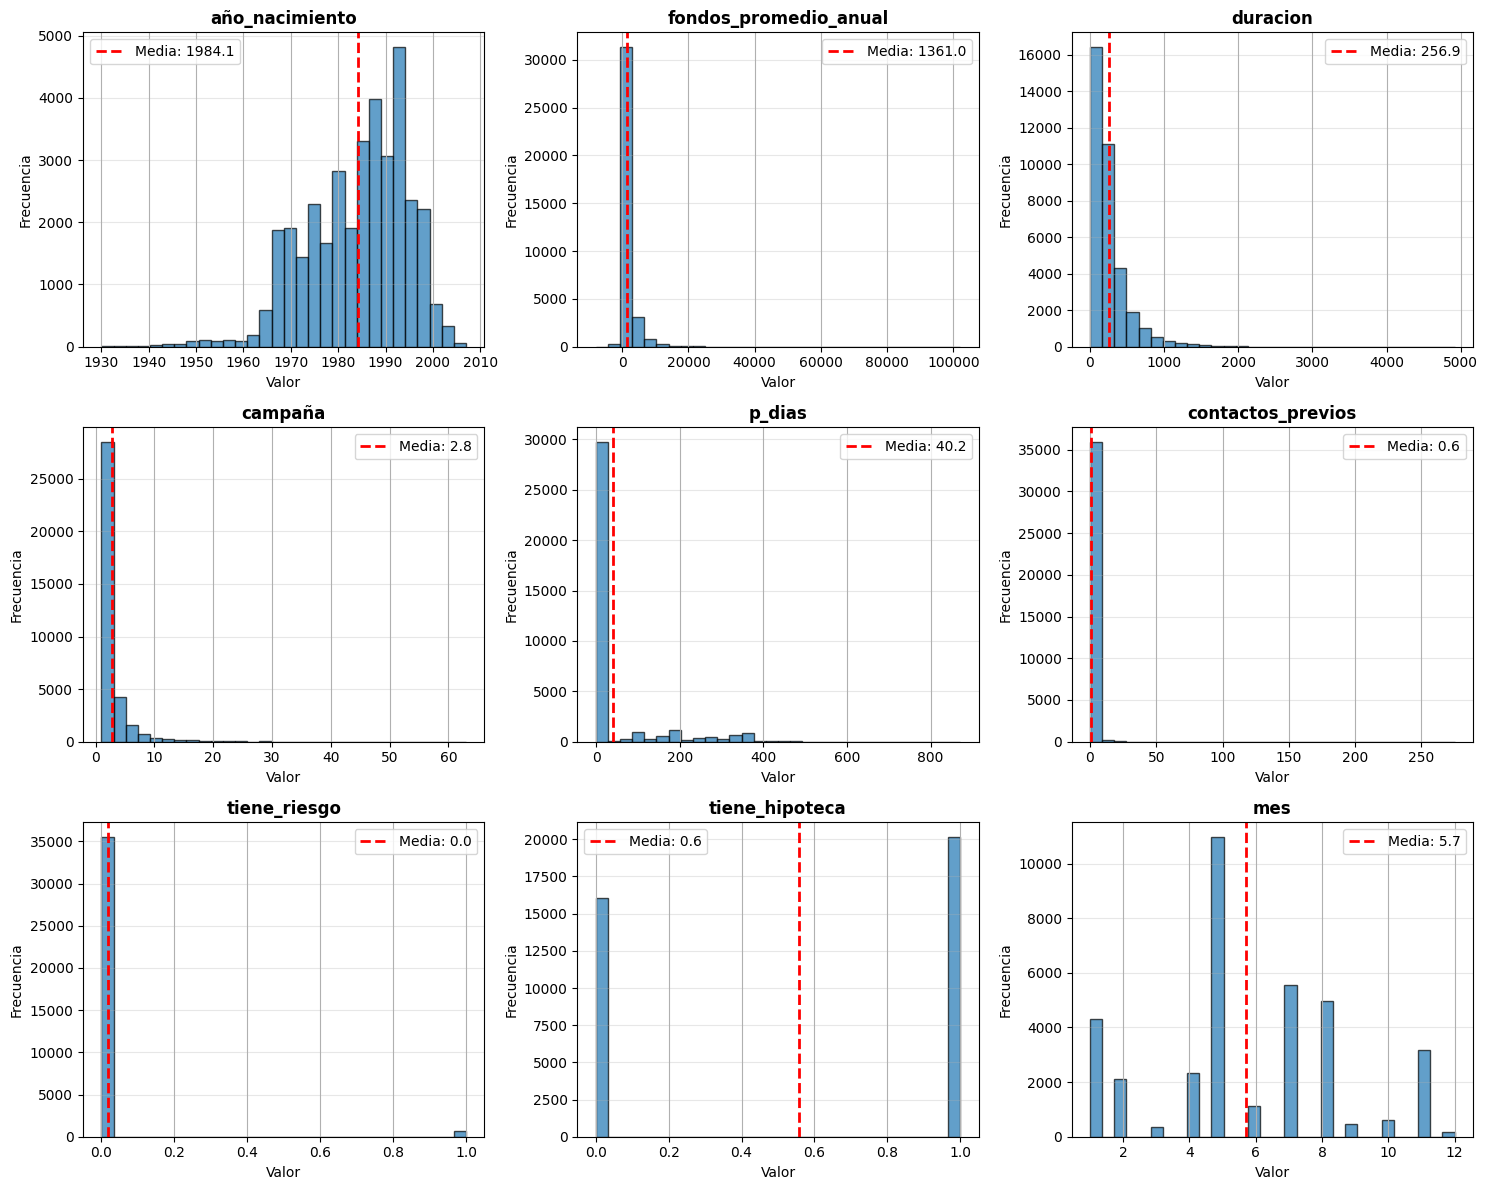


📊 Asimetría y Curtosis:
             Variable  Asimetría    Curtosis Interpretación_Asimetría
       año_nacimiento  -0.682596    0.306194     Asimétrica izquierda
fondos_promedio_anual   8.080110  130.740621       Asimétrica derecha
             duracion   3.250287   19.954450       Asimétrica derecha
              campaña   4.959564   40.137870       Asimétrica derecha
               p_dias   2.625594    7.046644       Asimétrica derecha
    contactos_previos  46.682042 5004.786011       Asimétrica derecha
         tiene_riesgo   7.102618   48.449868       Asimétrica derecha
       tiene_hipoteca  -0.228313   -1.947981                Simétrica
                  mes   0.087574   -0.482738                Simétrica

📊 Análisis de Outliers (Método IQR):
   año_nacimiento: 390 outliers (1.08%)
   fondos_promedio_anual: 3,788 outliers (10.47%)
   duracion: 2,589 outliers (7.16%)
   campaña: 2,467 outliers (6.82%)
   p_dias: 6,612 outliers (18.28%)
   contactos_previos: 6,612 outliers (18.

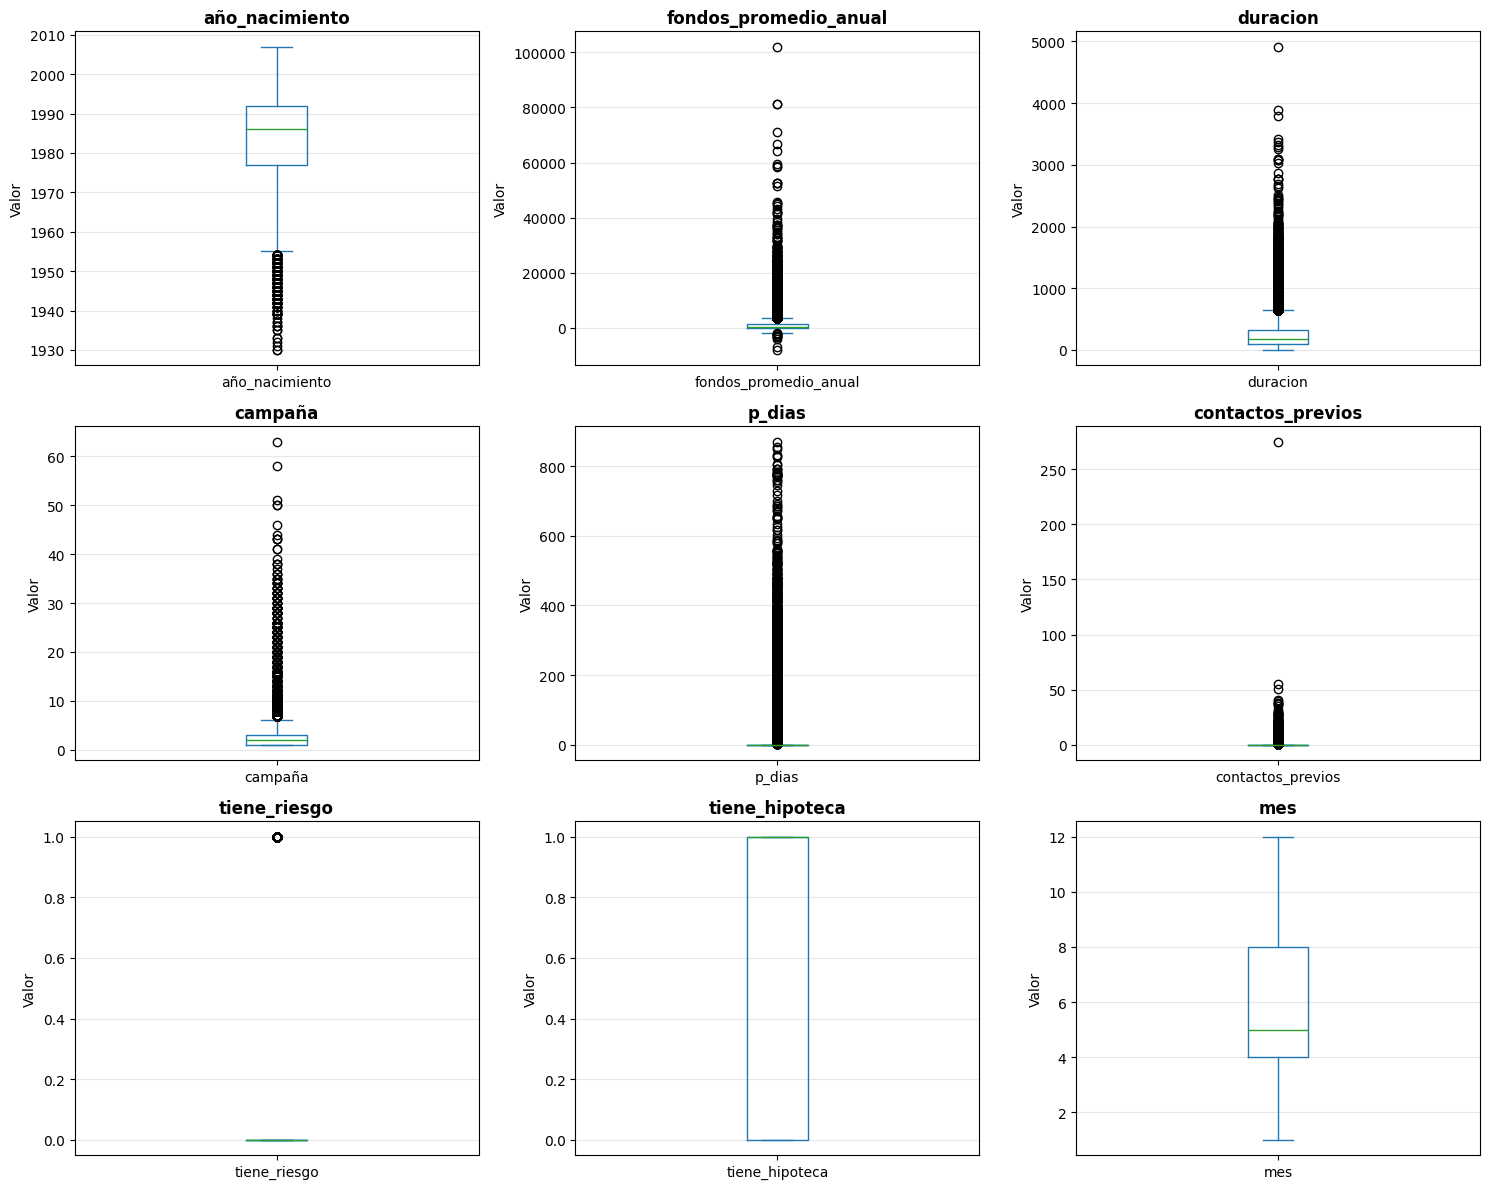


📊 Estadísticas Descriptivas:
                         count         mean          std     min     25%  \
año_nacimiento         36168.0  1984.069177    10.618369  1930.0  1977.0   
fondos_promedio_anual  36168.0  1361.046146  3023.083187 -8019.0    70.0   
duracion               36168.0   256.891202   256.884103     0.0   103.0   
campaña                36168.0     2.765649     3.120193     1.0     1.0   
p_dias                 36168.0    40.180076   100.107617    -1.0    -1.0   
contactos_previos      36168.0     0.580264     2.370668     0.0     0.0   
tiene_riesgo           36168.0     0.018718     0.135530     0.0     0.0   
tiene_hipoteca         36168.0     0.556708     0.496781     0.0     0.0   
mes                    36168.0     5.707172     2.819045     1.0     4.0   

                          50%     75%       max  
año_nacimiento         1986.0  1992.0    2007.0  
fondos_promedio_anual   447.0  1429.0  102127.0  
duracion                180.0   318.0    4918.0  
campaña  

In [382]:
"""
=================================================================
ANÁLISIS DE VARIABLES NUMÉRICAS - train_clean
=================================================================
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ========== IDENTIFICAR COLUMNAS NUMÉRICAS ==========
numeric_cols = train_clean.select_dtypes(include=[np.number]).columns.tolist()

# Excluir el target 'y' si existe
if 'y' in numeric_cols:
    numeric_cols.remove('y')

print("="*60)
print("ANÁLISIS DE VARIABLES NUMÉRICAS")
print("="*60)

print(f"\n📊 Variables numéricas encontradas: {len(numeric_cols)}")
print(f"   {numeric_cols}")

# ========== DISTRIBUCIONES (HISTOGRAMAS) ==========
if len(numeric_cols) > 0:
    print("\n📊 Generando histogramas...")

    n_cols = 3
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes

    for idx, col in enumerate(numeric_cols):
        if idx < len(axes):
            train_clean[col].hist(bins=30, ax=axes[idx], edgecolor='black', alpha=0.7)
            axes[idx].set_title(f'{col}', fontweight='bold', fontsize=12)
            axes[idx].set_xlabel('Valor')
            axes[idx].set_ylabel('Frecuencia')
            axes[idx].grid(axis='y', alpha=0.3)

            # Añadir línea de media
            media = train_clean[col].mean()
            axes[idx].axvline(media, color='red', linestyle='--', linewidth=2, label=f'Media: {media:.1f}')
            axes[idx].legend()

    # Ocultar ejes extras
    for idx in range(len(numeric_cols), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

    # ========== ESTADÍSTICAS DE ASIMETRÍA Y CURTOSIS ==========
    print("\n📊 Asimetría y Curtosis:")
    skew_kurt = pd.DataFrame({
        'Variable': numeric_cols,
        'Asimetría': [train_clean[col].skew() for col in numeric_cols],
        'Curtosis': [train_clean[col].kurtosis() for col in numeric_cols]
    })

    # Interpretar
    skew_kurt['Interpretación_Asimetría'] = skew_kurt['Asimetría'].apply(
        lambda x: 'Simétrica' if abs(x) < 0.5 else ('Asimétrica derecha' if x > 0 else 'Asimétrica izquierda')
    )

    print(skew_kurt.to_string(index=False))

    # ========== ANÁLISIS DE OUTLIERS ==========
    print("\n📊 Análisis de Outliers (Método IQR):")

    outliers_summary = []

    for col in numeric_cols:
        Q1 = train_clean[col].quantile(0.25)
        Q3 = train_clean[col].quantile(0.75)
        IQR = Q3 - Q1

        limite_inf = Q1 - 1.5 * IQR
        limite_sup = Q3 + 1.5 * IQR

        outliers = ((train_clean[col] < limite_inf) | (train_clean[col] > limite_sup)).sum()
        pct = (outliers / len(train_clean)) * 100

        outliers_summary.append({
            'Variable': col,
            'Outliers': outliers,
            'Porcentaje': f'{pct:.2f}%',
            'Límite Inf': f'{limite_inf:.2f}',
            'Límite Sup': f'{limite_sup:.2f}'
        })

        print(f"   {col}: {outliers:,} outliers ({pct:.2f}%)")

    # Crear DataFrame de resumen
    outliers_df = pd.DataFrame(outliers_summary)

    # ========== BOXPLOTS ==========
    print("\n📊 Generando boxplots...")

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes

    for idx, col in enumerate(numeric_cols):
        if idx < len(axes):
            train_clean[col].plot(kind='box', ax=axes[idx], vert=True)
            axes[idx].set_title(f'{col}', fontweight='bold', fontsize=12)
            axes[idx].set_ylabel('Valor')
            axes[idx].grid(axis='y', alpha=0.3)

    # Ocultar ejes extras
    for idx in range(len(numeric_cols), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

    # ========== ESTADÍSTICAS DESCRIPTIVAS ==========
    print("\n📊 Estadísticas Descriptivas:")
    print(train_clean[numeric_cols].describe().T)

else:
    print("\n⚠️  No se encontraron variables numéricas")

print("\n" + "="*60)
print("ANÁLISIS COMPLETADO")
print("="*60)

MATRIZ DE CORRELACIÓN

Dimensiones: (35, 35)
Total de variables: 35


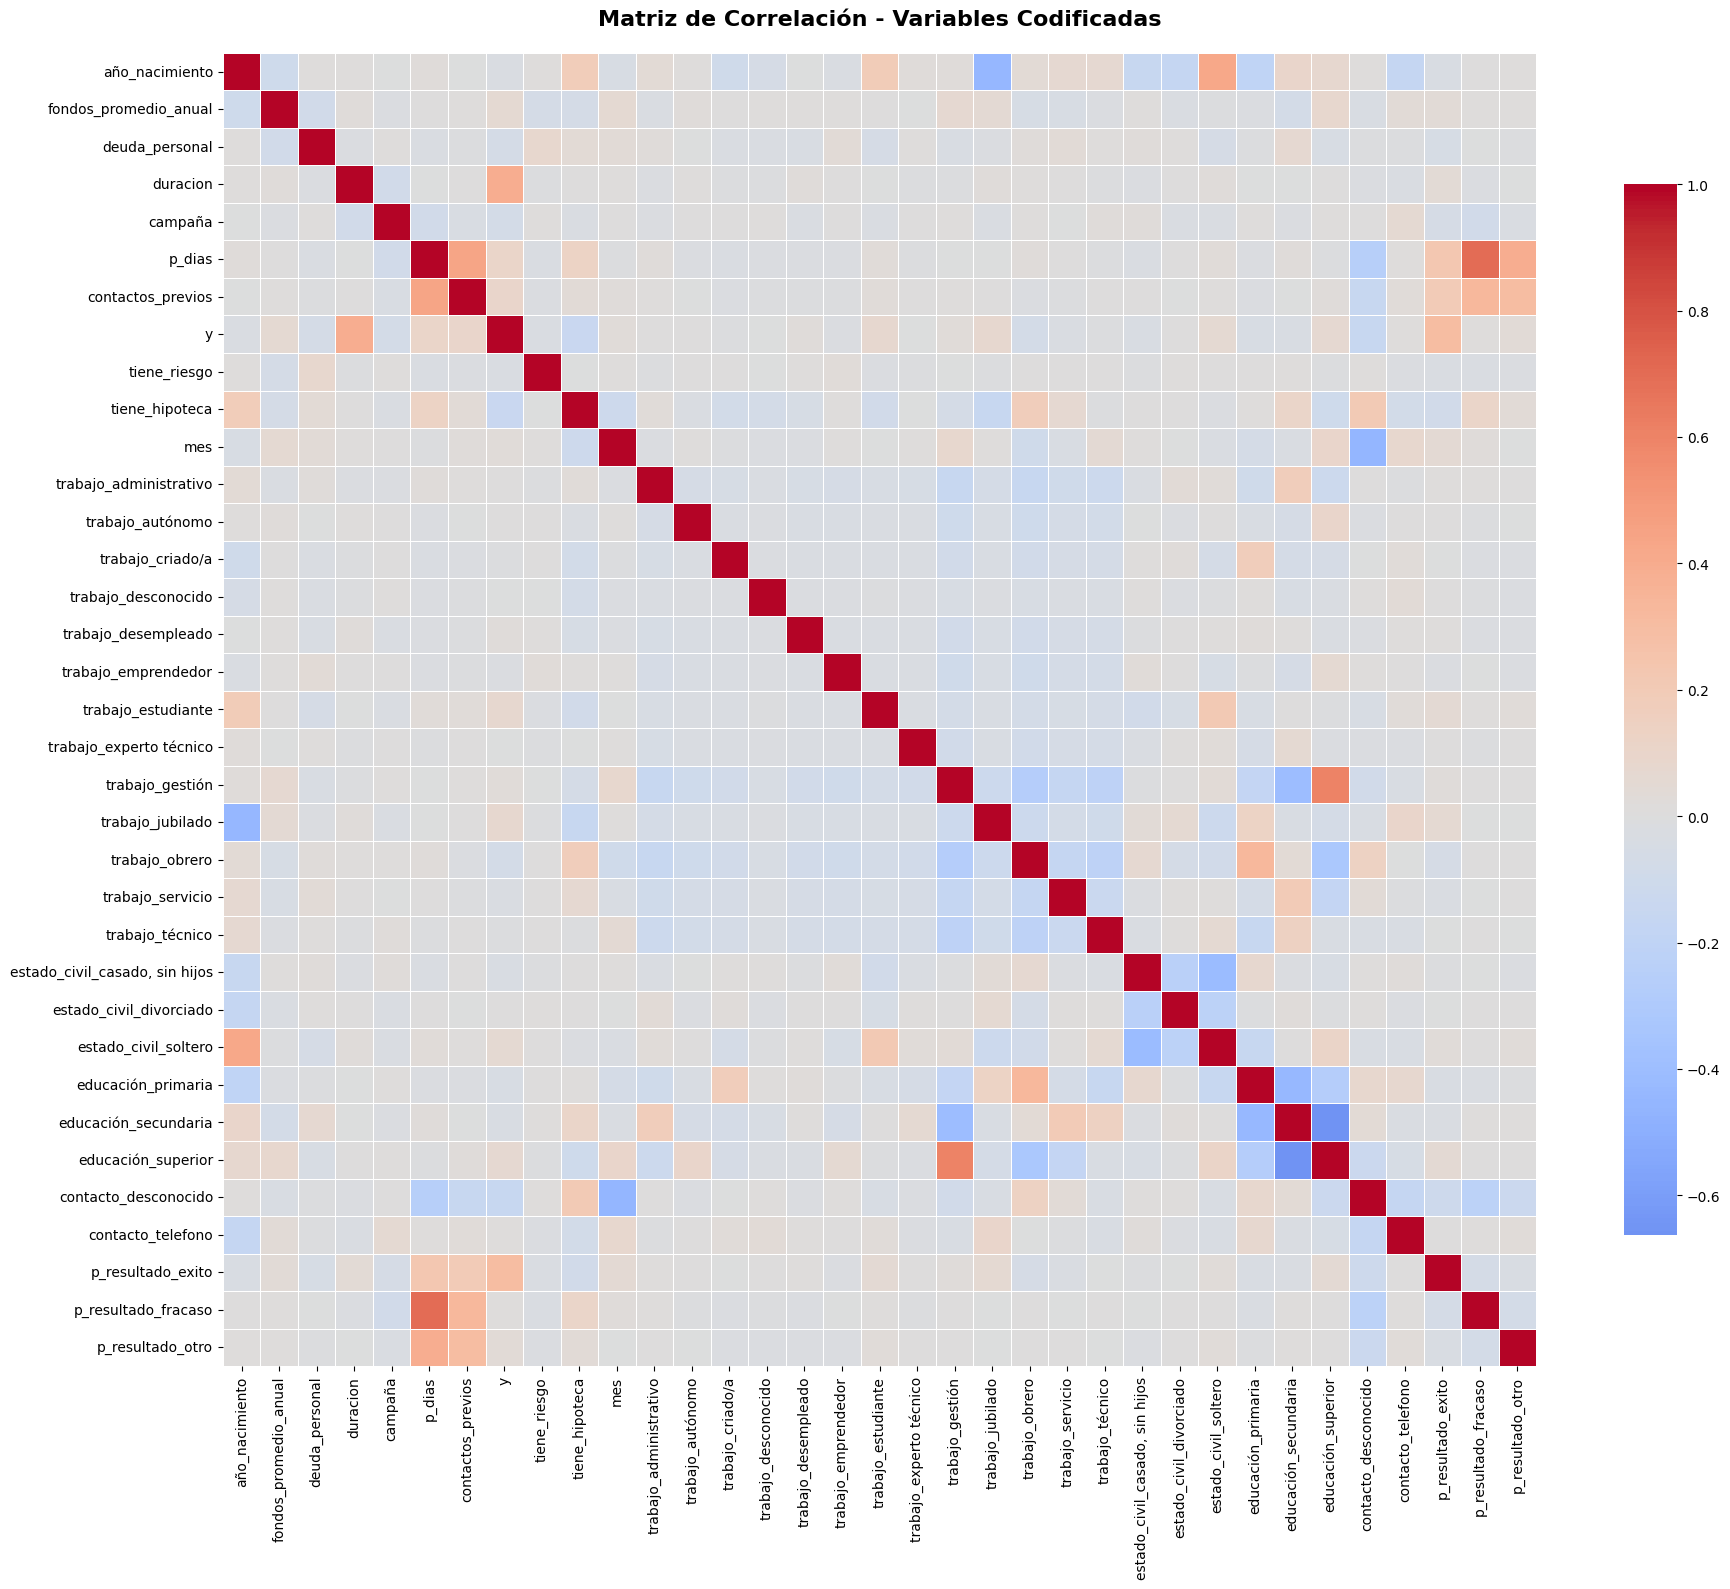


CORRELACIONES CON EL TARGET

Top 15 correlaciones más altas con el target:
y                        1.000000
duracion                 0.393402
p_resultado_exito        0.305084
p_dias                   0.105742
contactos_previos        0.092051
trabajo_jubilado         0.076440
trabajo_estudiante       0.073606
educación_superior       0.065868
estado_civil_soltero     0.061856
fondos_promedio_anual    0.052518
p_resultado_otro         0.035207
trabajo_gestión          0.030974
mes                      0.029190
trabajo_desempleado      0.023566
contacto_telefono        0.017208
p_resultado_fracaso      0.011747
Name: y, dtype: float64

Top 15 correlaciones más bajas (negativas) con el target:
trabajo_desconocido              -0.001127
trabajo_técnico                  -0.010775
trabajo_criado/a                 -0.011729
trabajo_emprendedor              -0.016888
tiene_riesgo                     -0.023934
trabajo_servicio                 -0.025259
año_nacimiento                   -0.026

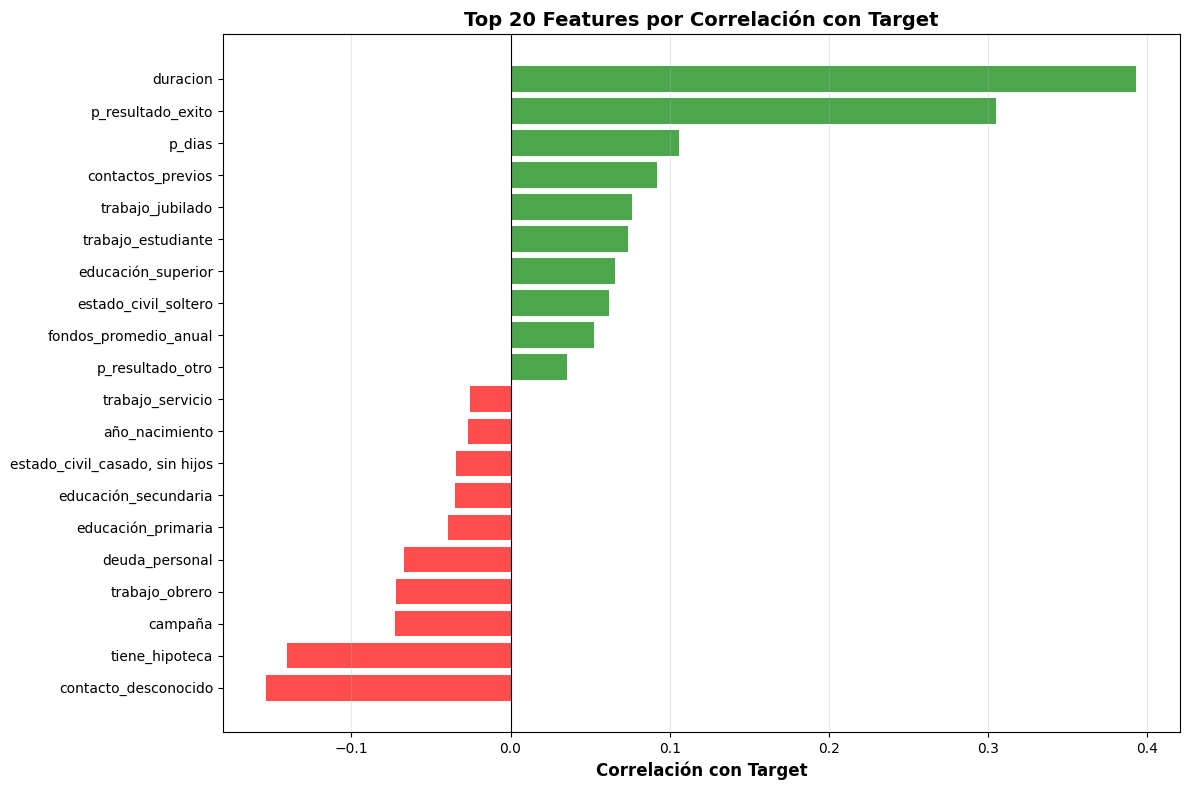


CORRELACIONES ALTAS ENTRE VARIABLES (Multicolinealidad)

✅ No hay correlaciones > 0.8 entre variables



In [383]:
"""
=================================================================
MATRIZ DE CORRELACIÓN - Datos Codificados
=================================================================
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ========== CALCULAR MATRIZ DE CORRELACIÓN ==========
# Asumiendo que train_encoded tiene todas las variables codificadas
corr_matrix = df.corr()

print("="*60)
print("MATRIZ DE CORRELACIÓN")
print("="*60)

print(f"\nDimensiones: {corr_matrix.shape}")
print(f"Total de variables: {len(corr_matrix.columns)}")

# ========== VISUALIZACIÓN COMPLETA ==========
plt.figure(figsize=(20, 16))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',          # Rojo-Azul
    center=0,                  # Centro en 0
    annot=False,               # Sin números (demasiadas variables)
    square=True,               # Celdas cuadradas
    linewidths=0.5,            # Líneas entre celdas
    cbar_kws={"shrink": 0.8}   # Barra de color
)

plt.title('Matriz de Correlación - Variables Codificadas',
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# ========== CORRELACIONES CON EL TARGET ==========
print("\n" + "="*60)
print("CORRELACIONES CON EL TARGET")
print("="*60)

# Correlación con 'y'
if 'y' in df.columns:
    target_corr = corr_matrix['y'].sort_values(ascending=False)

    print(f"\nTop 15 correlaciones más altas con el target:")
    print(target_corr.head(16))  # 16 para incluir 'y' consigo misma

    print(f"\nTop 15 correlaciones más bajas (negativas) con el target:")
    print(target_corr.tail(15))

    # ========== VISUALIZAR CORRELACIONES CON TARGET ==========
    # Excluir 'y' consigo misma
    target_corr_filtered = target_corr.drop('y')

    # Top 20 más correlacionadas (positivas y negativas)
    top_positive = target_corr_filtered.head(10)
    top_negative = target_corr_filtered.tail(10)
    top_features = pd.concat([top_positive, top_negative]).sort_values()

    plt.figure(figsize=(12, 8))
    colors = ['red' if x < 0 else 'green' for x in top_features.values]
    plt.barh(range(len(top_features)), top_features.values, color=colors, alpha=0.7)
    plt.yticks(range(len(top_features)), top_features.index, fontsize=10)
    plt.xlabel('Correlación con Target', fontsize=12, fontweight='bold')
    plt.title('Top 20 Features por Correlación con Target',
              fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# ========== CORRELACIONES ALTAS ENTRE VARIABLES ==========
print("\n" + "="*60)
print("CORRELACIONES ALTAS ENTRE VARIABLES (Multicolinealidad)")
print("="*60)

# Encontrar correlaciones altas (>0.8) excluyendo diagonal
high_corr = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr.append({
                'Variable_1': corr_matrix.columns[i],
                'Variable_2': corr_matrix.columns[j],
                'Correlación': corr_matrix.iloc[i, j]
            })

if high_corr:
    high_corr_df = pd.DataFrame(high_corr).sort_values('Correlación',
                                                        key=abs,
                                                        ascending=False)
    print(f"\n⚠️  {len(high_corr_df)} pares con correlación > 0.8:")
    print(high_corr_df.to_string(index=False))

    print("\n💡 Considera eliminar una de cada par para evitar multicolinealidad")
else:
    print("\n✅ No hay correlaciones > 0.8 entre variables")

print("\n" + "="*60)